In [5]:
%matplotlib inline

import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

from detrend_func import detrend_func
from window_func import main as window_func

import dask
from distributed import Client, LocalCluster
import dask.array as da

import xarray as xr
from netCDF4 import Dataset

In [2]:
# Create a Dask Distributed cluster with one processor and as many
# threads as cores
cluster = LocalCluster(n_workers=1)
client = Client(cluster)
client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.10/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:35511 Dashboard: http://127.0.0.1:38496/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


### Define constants to be used

In [3]:
dx = 80000. # meters
dy = 80000. # meters
dt = 1 # in days
H = [2000.0, 3000.0, 4000.0]  # meters
Htot = H[0] + H[1] + H[2]
Hm = 1000. # meters
f0 = 9.37456*(10**(-5)) #1/s (Coriolis parameter)
g = [1.2, .4]
rho = 1.0 # kg/(m^3)
Cp = 1000. # specific heat of atm in J/(kg*K)
T1 = 287
ocnorm = 1.0/(960*960) #from QGCM write-up
atnorm = 1/(384*96)
dt = 1 #86400.0 # seconds in a day (time difference between each point in time)
K2 = 2.5e4 # m^2/s (called st2d in input.params)
K4 = 2e14 # m^4/s (called st4d in input.params)
tmbaro = 3.04870e2 # mean ocean mixed layer absolute temperature (K)
tmbara = 3.05522e2 # mean atmosphere mixed layer absolute temperature (K)
toc1 = -1.78699e1 # Relative temperature for ocean layer 1

# --------------------------------
# The following are radiation constants output from the model
Bmup = -0.0213270418023 # ml eta coeffs
Dmup = 2.9649482139808 # temperature perturbation coeffs
A11down = 1.68632e-3 # QG internal interface eta coeffs
A12down = -1.63976e-3 # QG internal interface eta coeffs
B1down = 0.0116366566754 # ml eta coeffs

Dmdown = -3.2342349507402
D0up = 6.4271329356690
lamda = 35.00000 # sensible/latent heat flux coefficient (W m^2/kg) 
Fs_prime = 80.0 # perturbation amplitude of incoming solar radiation (W/m^2)


In [4]:
tile_size = 100

### Horizontal temperature advection

$$
\widehat{T^a}^* \widehat{ \left( u_m T_m \right)_x} + \widehat{T^a}^* \widehat{ \left( v_m T_m \right)_y}
$$
where
$$
u_m = - \frac{1}{f_0} p_{1y} - \frac{1}{f_0 H_m} \tau ^y \\
v_m = \frac{1}{f_0} p_{1x} + \frac{1}{f_0 H_m} \tau ^x
$$

In [24]:
def calc_H_adv(dsx1, dsx2, tile_index, z=0): 
    
    # dsx1 is atpa
    # dsx2 is atast
    
    # Select variable
    T = dsx2.ast
    p = dsx1.p.isel(z=0)
    taux = dsx1.taux
    tauy = dsx1.tauy

    # Select specified tile, with 2-cell padding for taking of derivatives
    ix, iy = tile_index
    
    # First define the start and end x-slices to deal with periodic boundaries
    pstart = p.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(0,2))
    tauxstart = taux.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(0,2))
    tauystart = tauy.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(0,2))
    Tstart = T.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(0,1))
    pend = p.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(-1,None))
    tauxend = taux.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(-1,None))
    tauyend = tauy.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(-1,None))
    Tend = T.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(-1,None))
    
    T = T.isel(yt=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
               xt=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))
    p = p.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+2), # +2 because p and tau on p-grid, T on T-grid
               xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+2))
    taux = taux.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+2),
                 xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+2))
    tauy = tauy.isel(yp=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+2),
                 xp=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+2))
    
    print('pstart and pend shape = ',pstart.shape,pend.shape)
    
    print('T, p shape after isel = ',T.shape,p.shape)
    
    xt = T.xt.values # grab values of dask arrays
    yt = T.yt.values
    time = T.time.values
    
    T = T.data
    p = p.data
    taux = taux.data
    tauy = tauy.data
    
    # Concatenate end pieces on
    if ix == 0: # first x-chunk
        p = da.concatenate([pend,p],axis=1)
        taux = da.concatenate([tauxend,taux],axis=1)
        tauy = da.concatenate([tauyend,tauy],axis=1)
        T = da.concatenate([Tend,T],axis=1)
        print('p, taux, tauy shape after concat = ',p.shape,taux.shape,tauy.shape)
    if ix == 3: #last x-chunk
        p = da.concatenate([p,pstart],axis=1)
        taux = da.concatenate([taux,tauxstart],axis=1)
        tauy = da.concatenate([tauy,tauystart],axis=1)
        T = da.concatenate([T,Tstart],axis=1)
        print('p, taux, tauy shape after concat = ',p.shape,taux.shape,tauy.shape)
    
    # Average p and tau dimensions to match T-grid
    p = 0.5 * (p[1:,:,:]+p[:-1,:,:])
    p = 0.5 * (p[:,1:,:]+p[:,:-1,:])
    tauy_avg = 0.5 * (tauy[1:,:,:] + tauy[:-1,:,:])
    tauy_avg = 0.5 * (tauy_avg[:,1:,:] + tauy_avg[:,:-1,:])
    taux_avg = 0.5 * (taux[1:,:,:] + taux[:-1,:,:])
    taux_avg = 0.5 * (taux_avg[:,1:,:] + taux_avg[:,:-1,:])
    print('p and tauy_avg.shape = ',p.shape,tauy_avg.shape)
    
    # Update size variables
    ny, nx, nt = T.shape
    T = T.rechunk(chunks={0: ny, 1: nx})
    p = p.rechunk(chunks={0: ny, 1: nx})
    taux_avg = taux_avg.rechunk(chunks={0: ny, 1: nx})
    tauy_avg = tauy_avg.rechunk(chunks={0: ny, 1: nx})
    
    
    # Take a single derivative using centered diff
    def Derivative(var, axis):
        var_right = np.roll(var, 1, axis=axis)
        var_left = np.roll(var, -1, axis=axis)
        dvar = var_left - var_right
        return dvar
        
    Derivative_x = lambda p: Derivative(p, 1)
    Derivative_y = lambda p: Derivative(p, 0)
    
    # Evaluate the derivative function
    dpdx = (1./(2*dx)) * p.map_blocks(Derivative_x)
    dpdy = (1./(2*dx)) * p.map_blocks(Derivative_y)
    print('dpdx.shape = ',dpdx.shape)

    # Define ml velocities
    um = -(1./f0) * dpdy - (1./(f0*Hm)) * tauy_avg
    vm = (1./f0) * dpdx + (1./(f0*Hm)) * taux_avg
    print('um.shape, vm.shape = ',um.shape,vm.shape)
    
    # Velocity * Temp
    umTm = um * T
    vmTm = vm * T
    
    # Take derivatives of these terms
    umTm_x = (1./(2*dx)) * umTm.map_blocks(Derivative_x)
    vmTm_y = (1./(2*dx)) * vmTm.map_blocks(Derivative_y)
    
    print('umTm_x shape = ',umTm_x.shape)
    
    # Trim arrays of extra ends
    umTm_x = umTm_x[1:-1, 1:-1, :]
    vmTm_y = vmTm_y[1:-1, 1:-1, :]
    T = T[1:-1, 1:-1, :]
    print('after trimming cells ',T.shape,umTm_x.shape)
    
    # Use smaller spatial chunks for fft
    T = T.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    umTm_x = umTm_x.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    vmTm_y = vmTm_y.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    
    print('p shape after chunking/10 = ',T.shape)
        
    # Function that detrends, windows, and takes fft
    def fft_block(var):
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1./var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Execute fft function above
    That = T.map_blocks(fft_block)
    umTm_xhat = umTm_x.map_blocks(fft_block)
    vmTm_yhat = vmTm_y.map_blocks(fft_block)
    
    # Rechunk back to tile_size
    That = That.rechunk(chunks={0: tile_size, 1:tile_size, 2: 365})
    umTm_xhat = umTm_xhat.rechunk(chunks={0: tile_size, 1:tile_size, 2: 365})
    vmTm_yhat = vmTm_yhat.rechunk(chunks={0: tile_size, 1:tile_size, 2: 365})

    # Multiply together and take the real part
    TumTm_x = ((That.conj()*umTm_xhat).real)
    TvmTm_y = ((That.conj()*vmTm_yhat).real)
    print('final shape = ',TumTm_x.shape)

    # Sum over x- and y-axes
    TumTm_x = da.sum(TumTm_x, axis=(0,1))
    TvmTm_y = da.sum(TvmTm_y, axis=(0,1))
    
    # Tell dask to compute the values
    TumTm_x = TumTm_x.compute()
    TvmTm_y = TvmTm_y.compute()
    
    # Wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    TumTm_x = xr.DataArray(TumTm_x, 
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xt': xt.mean(),
                              'yt': yt.mean()})
    
    TvmTm_y = xr.DataArray(TvmTm_y, 
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xt': xt.mean(),
                              'yt': yt.mean()})
    
    return TumTm_x,TvmTm_y

In [26]:
Hu,Hv = calc_H_adv(dsx1,dsx2,(0,0),0)

pstart and pend shape =  (97, 2, 365) (97, 1, 365)
T, p shape after isel =  (96, 101, 365) (97, 102, 365)
T and p shape with buffer of 2 on either side =  (96, 101, 365) (97, 102, 365)
p, taux, tauy shape after concat =  (97, 103, 365) (97, 103, 365) (97, 103, 365)
p and tauy_avg.shape =  (96, 102, 365) (96, 102, 365)
dpdx.shape =  (96, 102, 365)
um.shape, vm.shape =  (96, 102, 365) (96, 102, 365)
umTm_x shape =  (96, 102, 365)
after trimming cells  (94, 100, 365) (94, 100, 365)
p shape after chunking/10 =  (94, 100, 365)
final shape =  (94, 100, 365)


### Vertical temperature advection


$$
\frac{1}{H_m} \widehat{T^a}^* \widehat{ w_{ek} T_m}
$$


In [156]:
def calc_vert_adv(dsx, tile_index, z=0):
    
    # Select variables
    T = dsx.ast
    wekt = dsx.wekt
    
    # Work with DaskArrays
    ix, iy = tile_index
    T = T.isel(yt=slice(max(iy*tile_size,0), (iy+1)*tile_size),
                 xt=slice(max(ix*tile_size,0), (ix+1)*tile_size))
    wekt = wekt.isel(yt=slice(max(iy*tile_size,0), (iy+1)*tile_size),
                 xt=slice(max(ix*tile_size,0), (ix+1)*tile_size))

    xt = T.xt.values
    yt = T.yt.values
    time = T.time.values
    
    T = T.data
    wekt = wekt.data
    
    print('original shapes of wekt and T = ',wekt.shape,T.shape)
    
    ny, nx, nt = T.shape
    T = T.rechunk(chunks={0: ny, 1: nx})
    wekt = wekt.rechunk(chunks={0: ny, 1: nx})   
    print('wekt shape = ',wekt.shape,T.shape)
    
    wekT = wekt * T
    
    # Take fft (after detrend and window)
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1./var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Use smaller spatial chunks for fft
    T = T.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    wekT = wekT.rechunk(chunks={0: tile_size/10, 
                                  1: tile_size/10, 
                                  2: nt})
    
    # Execute fft function above
    That = T.map_blocks(fft_block)
    wekThat = wekT.map_blocks(fft_block)
    
    #pdiffhat = da.fft.rfft(pdiff, axis=2)
    That = That.rechunk( chunks={0: tile_size, 1:tile_size, 2: 365})
    wekThat = wekThat.rechunk(chunks={0: tile_size, 
                                        1: tile_size, 
                                        2: 365})
    # Multiply by constants
    vert_adv = (1./Hm) * (That.conj()*wekThat).real

    # Sum over x- and y-axes
    vert_adv = da.sum(vert_adv, axis=(0,1))
    
    vert_adv = vert_adv.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    vert_adv = xr.DataArray(vert_adv,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xt': xt.mean(),
                              'yt': yt.mean()})
    return vert_adv

In [157]:
vert = calc_vert_adv(dsx2,(3,0))

original shapes of wekt and T =  (96, 84, 365) (96, 84, 365)
wekt shape =  (96, 84, 365) (96, 84, 365)


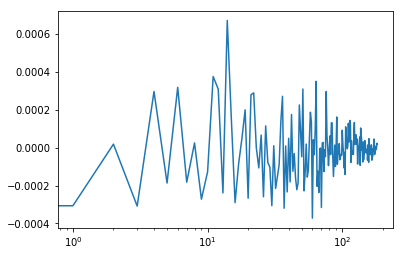

In [158]:
plt.semilogx(vert)

## All terms of the form:

$$
{}^a \widehat{T_m}^* {}^a \widehat{\eta _m}
$$


In [159]:
def calc_Tana(dsx1, tile_index):
    # Select variables
    Ta = dsx1.ast
    hm = dsx1.hmixa
    
    # Work with DaskArrays
    ix, iy = tile_index
    Ta = Ta.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(ix*tile_size, (ix+1)*tile_size))
    hm = hm.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(ix*tile_size, (ix+1)*tile_size))
    
    print('Ta, hm shapes after isel = ',Ta.shape, hm.shape)
    
    xt = Ta.xt.values
    yt = Ta.yt.values
    time = Ta.time.values
    
    Ta = Ta.data
    hm = hm.data
    
    ny, nx, nt = Ta.shape
    
    print('Original shape = ',Ta.shape)
    
    # Define eta_m = h_m - H_m
    nm = hm - Hm
    nm = nm/hm
    print('nm shape = ',nm.shape)
 
    # Take fft (after detrend and window)
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Resize for faster FFT
    Ta = Ta.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    nm = nm.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})

    # Execute fft function above
    Tahat = Ta.map_blocks(fft_block)
    nmhat = nm.map_blocks(fft_block)
    
    # Resize back to original tile size (100)
    Tahat = Tahat.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    nmhat = nmhat.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    
    # Multiply by constants
    Tana = (Tahat.conj()*nmhat).real

    # Sum over x- and y-axes
    Tana = da.sum(Tana, axis=(0,1))
    
    Tana = Tana.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    Tana = xr.DataArray(Tana,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xt': xt.mean(),
                              'yt': yt.mean()})
    
    return Tana

In [160]:
Tan = calc_Tana(dsx2,(3,0))

Ta, hm shapes after isel =  (96, 84, 365) (96, 84, 365)
Original shape =  (96, 84, 365)
nm shape =  (96, 84, 365)
Aftermasking =  (96, 84, 365)


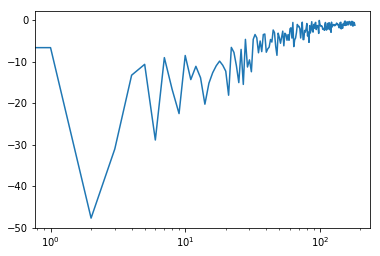

In [161]:
plt.semilogx(Tan)

## All terms of the form:

$$
{}^a \widehat{T}^* {}^a \widehat{T}
$$


In [168]:
def calc_Ta2(dsx1, tile_index):
    # Select variables
    T = dsx1.ast
    hm = dsx1.hmixa

    # Work with DaskArrays
    ix, iy = tile_index
    T = T.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(ix*tile_size, (ix+1)*tile_size))
    hm = hm.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(ix*tile_size, (ix+1)*tile_size))
    
    print('To shape after isel = ',T.shape)
    
    xt = T.xt.values
    yt = T.yt.values
    time = T.time.values
    
    T = T.data
    
    ny, nx, nt = T.shape
    
    print('Original shape = ',T.shape)

    # Divide by hm
    Thm = T/hm
        
    print('Aftermasking = ',T.shape)
 
    # Take fft (after detrend and window)
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Resize for faster FFT
    T = T.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    Thm = Thm.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})

    # Execute fft function above
    That = T.map_blocks(fft_block)
    Thmhat = Thm.map_blocks(fft_block)
    
    # Resize back to original tile size (100)
    That = That.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    Thmhat = Thmhat.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    
    # Multiply by constants
    T2 = (That.conj()*Thmhat).real

    # Sum over x- and y-axes
    Ta2 = da.sum(T2, axis=(0,1))
    
    Ta2 = Ta2.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    Ta2 = xr.DataArray(Ta2,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xt': xt.mean(),
                              'yt': yt.mean()})
    
    return Ta2

In [169]:
Ta2 = calc_Ta2(dsx2,(3,0))

To shape after isel =  (96, 84, 365)
Original shape =  (96, 84, 365)
Aftermasking =  (96, 84, 365)


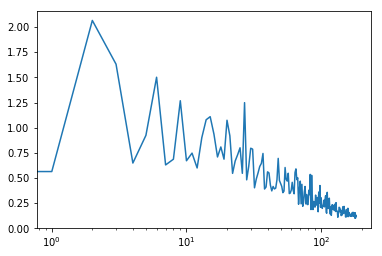

In [170]:
plt.semilogx(Ta2)

## All terms of the form:

$$
{}^a \widehat{T}^* {}^a \widehat{\eta _1}
$$


In [171]:
def calc_Tn1(dsx1, dsx2, tile_index):
    # Select variables
    T = dsx2.ast
    hm = dsx2.hmixa
    p1 = dsx1.p.isel(z=0)
    p2 = dsx1.p.isel(z=1)
    
    print('Original shape = ',T.shape,p1.shape,p2.shape)
    
    # Work with DaskArrays
    ix, iy = tile_index
    # First define the start and end x-slices to deal with periodic boundaries
    p1end = p1.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(0,1))
    p2end = p2.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(0,1))
    T = T.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(ix*tile_size, (ix+1)*tile_size))
    p1 = p1.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size+1))
    p2 = p2.isel(yp=slice(iy*tile_size, (iy+1)*tile_size),
                 xp=slice(ix*tile_size, (ix+1)*tile_size+1))
    hm = hm.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(ix*tile_size, (ix+1)*tile_size))
    
    print('p1end shape = ',p1end.shape)
    
    print('T, p1, p2 shape after isel = ',T.shape,p1.shape,p2.shape)
    
    xt = T.xt.values
    yt = T.yt.values
    time = T.time.values
    
    T = T.data
    p1 = p1.data
    p2 = p2.data

    # Concatenate end pieces on
    if ix == 3:
        p1 = da.concatenate([p1,p1end],axis=1)
        print('p1 shape after concat = ',p1.shape)
        p2 = da.concatenate([p2,p2end],axis=1)
        print('p2 shape after concat = ',p2.shape)
    
    ny, nx, nt = T.shape
    
    p1T = 0.25 * (p1[1:,1:,:] + p1[:-1,:-1,:])
    p2T = 0.25 * (p2[1:,1:,:] + p2[:-1,:-1,:])
    
    print('p1T shape = ',p1T.shape)
    
    n1 = (1/g[0]) * (p1T - p2T)
    n1 = n1/hm
    print('n1 shape = ',n1.shape)
 
    # Take fft (after detrend and window)
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Resize for faster FFT
    T = T.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    n1 = n1.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})

    # Execute fft function above
    That = T.map_blocks(fft_block)
    nhat = n1.map_blocks(fft_block)
    
    # Resize back to original tile size (100)
    That = That.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    nhat = nhat.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    
    # Multiply by constants
    Tn1 = (That.conj()*nhat).real

    # Sum over x- and y-axes
    Tn1 = da.sum(Tn1, axis=(0,1))
    
    Tn1 = Tn1.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    Tn1 = xr.DataArray(Tn1,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xt': xt.mean(),
                              'yt': yt.mean()})
    
    return Tn1

In [174]:
Tn1_tile30 = calc_Tn1(dsx1,dsx2,(0,0))

Original shape =  (96, 384, 365) (97, 384, 365) (97, 384, 365)
p1end shape =  (97, 1, 365)
T, p1, p2 shape after isel =  (96, 100, 365) (97, 101, 365) (97, 101, 365)
p1T shape =  (96, 100, 365)
n1 shape =  (96, 100, 365)
Aftermasking =  (96, 100, 365)


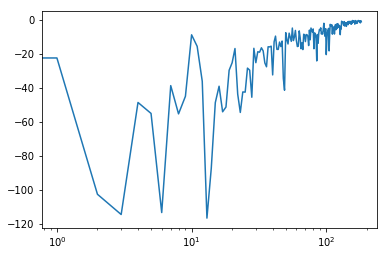

In [175]:
plt.semilogx(Tn1_tile30)

# Calculate grad squared term

$$
\widehat{T^o}^* \widehat{\nabla ^2 T^o}
$$

In [27]:
def calc_Tdel2T(dsx1, tile_index):
    # Select variables
    T = dsx1.ast
    
    # Work with DaskArrays
    ix, iy = tile_index
    # First define the start and end x-slices to deal with periodic boundaries
    Tstart = T.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(0,1))
    Tend = T.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(-1,None))
    T = T.isel(yt=slice(max(iy*tile_size-1,0), (iy+1)*tile_size+1),
               xt=slice(max(ix*tile_size-1,0), (ix+1)*tile_size+1))
    
    print('T shape after isel = ',T.shape)
    
    xt = T.xt.values
    yt = T.yt.values
    time = T.time.values
    
    T = T.data
    
    # Concatenate end pieces on
    if ix == 0:
        T = da.concatenate([Tend,T],axis=1)
        print('T shape after concat = ',T.shape)
    if ix == 3:
        T = da.concatenate([T,Tstart],axis=1)
        print('T shape after concat = ',T.shape)
    
    ny, nx, nt = T.shape
    T = T.rechunk(chunks={0: ny, 1: nx})
    print('Original shape = ',T.shape)
    
    # Take a second derivative
    def Derivative(var, axis):
        var_right = np.roll(var, 1, axis=axis)
        var_left = np.roll(var, -1, axis=axis)
        dvar = var_left + var_right - 2*var
        return dvar
    
    Derivative_x = lambda p: Derivative(p, 1)
    Derivative_y = lambda p: Derivative(p, 0)
    
    # Evaluate the derivative function
    del2_x = (1./(dx**2)) * T.map_blocks(Derivative_x)
    del2_y = (1./(dx**2)) * T.map_blocks(Derivative_y)
    
    print('del2x shape = ',del2_x.shape)
    print('del2y shape = ',del2_y.shape)
    print('dx = ',dx)
    
    del2 = del2_x + del2_y
    print('del2.shape = ',del2.shape)
    
    # Take off added cells
    T = T[1:-1,1:-1,:]
    del2 = del2[1:-1,1:-1,:]
    print('Aftermasking = ',T.shape,del2.shape)
 
    # Take fft (after detrend and window)
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Resize for faster FFT
    T = T.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    del2 = del2.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})

    # Execute fft function above
    That = T.map_blocks(fft_block)
    del2hat = del2.map_blocks(fft_block)
    
    # Resize back to original tile size (100)
    That = That.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    del2hat = del2hat.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    
    # Multiply by constants
    Tdel2T = (That.conj()*del2hat).real

    # Sum over x- and y-axes
    Tdel2T = da.sum(Tdel2T, axis=(0,1))
    
    Tdel2T = Tdel2T.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    Tdel2T = xr.DataArray(Tdel2T,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xt': xt.mean(),
                              'yt': yt.mean()})
    
    return Tdel2T

In [28]:
tile30 = calc_Tdel2T(dsx2,(0,0))

T shape after isel =  (96, 101, 365)
T shape after concat =  (96, 102, 365)
Original shape =  (96, 102, 365)
del2x shape =  (96, 102, 365)
del2y shape =  (96, 102, 365)
dx =  80000.0
del2.shape =  (96, 102, 365)
Aftermasking =  (94, 100, 365) (94, 100, 365)


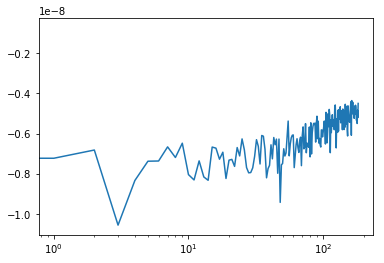

In [29]:
plt.semilogx(tile30)

# Calculate grad fourth term

$$
\widehat{T^o}^* \widehat{\nabla ^4 T^o}
$$

In [30]:
def calc_Tdel4T(dsx1, tile_index):
    # Select variables
    T = dsx1.ast
    
    # Work with DaskArrays
    ix, iy = tile_index
    # First define the start and end x-slices to deal with periodic boundaries
    Tstart = T.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(None,2))
    Tend = T.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(-2,None))
    T = T.isel(yt=slice(max(iy*tile_size-2,0), (iy+1)*tile_size+2),
               xt=slice(max(ix*tile_size-2,0), (ix+1)*tile_size+2))
    
    print('T shape after isel = ',T.shape)
    
    xt = T.xt.values
    yt = T.yt.values
    time = T.time.values
    
    T = T.data
    
    # Concatenate end pieces on
    if ix == 0:
        T = da.concatenate([Tend,T],axis=1)
        print('T shape after concat = ',T.shape)
    if ix == 3:
        T = da.concatenate([T,Tstart],axis=1)
        print('T shape after concat = ',T.shape)
    
    ny, nx, nt = T.shape
    T = T.rechunk(chunks={0: ny, 1: nx})
    
    print('Original shape = ',T.shape)
    
    # Take a fourth derivative
    def Derivative(var, axis):
        var_right = np.roll(var, 1, axis=axis)
        var_2right = np.roll(var, 2, axis=axis)
        var_left = np.roll(var, -1, axis=axis)
        var_2left = np.roll(var, -2, axis=axis)
        dvar = var_2left - 4*var_left + 6*var - 4*var_right + var_2right
        return dvar
        
    Derivative_x = lambda p: Derivative(p, 1)
    Derivative_y = lambda p: Derivative(p, 0)
    
    # Evaluate the derivative function
    del4_x = (1./(dx**4)) * T.map_blocks(Derivative_x)
    del4_y = (1./(dx**4)) * T.map_blocks(Derivative_y)
    
    print('dpdx shape = ',del4_x.shape)
    print('tauy_avg shape = ',del4_y.shape)
    
    del4 = del4_x + del4_y
    
    print('del4.shape = ',del4.shape)
    
    # Take off added cells
    T = T[2:-2,2:-2,:]
    del4 = del4[2:-2,2:-2,:]
    print('Aftermasking = ',T.shape,del4.shape)
 
    # Take fft (after detrend and window)
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Resize for faster FFT
    T = T.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    del4 = del4.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})

    # Execute fft function above
    That = T.map_blocks(fft_block)
    del4hat = del4.map_blocks(fft_block)
    
    # Resize back to original tile size (100)
    That = That.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    del4hat = del4hat.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    
    # Multiply by constants
    Tdel4T = (That.conj()*del4hat).real

    # Sum over x- and y-axes
    Tdel4T = da.sum(Tdel4T, axis=(0,1))
    
    Tdel4T = Tdel4T.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    Tdel4T = xr.DataArray(Tdel4T,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xt': xt.mean(),
                              'yt': yt.mean()})
    
    return Tdel4T

In [31]:
T43 = calc_Tdel4T(dsx2,(0,0))

T shape after isel =  (96, 102, 365)
T shape after concat =  (96, 104, 365)
Original shape =  (96, 104, 365)
dpdx shape =  (96, 104, 365)
tauy_avg shape =  (96, 104, 365)
del4.shape =  (96, 104, 365)
Aftermasking =  (92, 100, 365) (92, 100, 365)


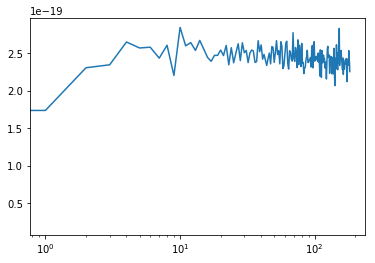

In [32]:
plt.semilogx(T43)

# Land points

In [7]:
def calc_TFs(dsx1, tile_index):
    # Select variables
    T = dsx1.ast
    hm = dsx1.hmixa
    
    # Work with DaskArrays
    ix, iy = tile_index
    T = T.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(ix*tile_size, (ix+1)*tile_size))
    hm = hm.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(ix*tile_size, (ix+1)*tile_size))
    
    print('To shape after isel = ',T.shape)
    
    # Set ocean points to zero
    #  - there are 38 atm points over ocean in ix=1
    #  - here I slice the land portions into rectangles
    if ix == 1:
        print('ix==1')
        
        T_left = T.isel(xt=slice(None,62))
        T_top = T.isel(yt=slice(-18,None),xt=slice(62,None))
        T_bot = T.isel(yt=slice(None,18),xt=slice(62,None))
        
        T_zeros = T.isel(yt=slice(18,-18),xt=slice(62,None)) # grab only the ocean points
        T_zeros = T_zeros.where(T_zeros>10000,0) # set all ocean points to zero: if T_zeros>10000 is false, fill with zeros
        print(T_zeros.isel(xt=slice(4,5),yt=slice(3,4),time=slice(3,4)))
        print('T_left,T_top,T_bot,T_zeros shapes = ',T_left.shape,T_top.shape,T_bot.shape,T_zeros.shape)
        
        # Concatenate right side of chunk
        T_right = xr.concat([T_top,T_zeros,T_bot],'yt')
        print(T_right.shape)
        
        # Concatenate entire chunk together
        T = xr.concat([T_left,T_right],'xt')
        print('T.shape = ',T.shape)
        
    # Set ocean points to zero
    #  - there are 22 atm points over ocean in ix=2
    elif ix == 2:
        
        T_right = T.isel(xt=slice(22,None))
        T_top = T.isel(yt=slice(-18,None),xt=slice(None,22))
        T_bot = T.isel(yt=slice(None,18),xt=slice(None,22))
        
        T_zeros = T.isel(yt=slice(18,-18),xt=slice(None,22))
        T_zeros = T_zeros.where(T_zeros>10000,0)
        print(T_zeros.isel(xt=slice(None,5),yt=slice(3,4),time=slice(3,4)))
        print('T_right,T_top,T_bot,T_zeros shapes = ',T_right.shape,T_top.shape,T_bot.shape,T_zeros.shape)
        
        T_left = xr.concat([T_top,T_zeros,T_bot],'yt')
        print(T_left.shape)
        
        T = xr.concat([T_left,T_right],'xt')
        print('T.shape = ',T.shape)
        
        
    hminv = 1/hm
    
    xt = T.xt.values
    yt = T.yt.values
    time = T.time.values
    
    
    T = T.data
    hminv = hminv.data
    
    ny, nx, nt = T.shape
    
    
    print('Original shape = ',T.shape)
 
    # Take fft (after detrend and window)
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Resize for faster FFT
    T = T.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    hminv = hminv.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})

    # Execute fft function above
    That = T.map_blocks(fft_block)
    hminvhat = hminv.map_blocks(fft_block)
    
    # Resize back to original tile size (100)
    That = That.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    hminvhat = hminvhat.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    
    # Multiply by constants
    TFs = (That.conj()*hminvhat).real

    # Sum over x- and y-axes
    TFs = da.sum(TFs, axis=(0,1))
    
    TFs = TFs.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    TFs = xr.DataArray(TFs,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xt': xt.mean(),
                              'yt': yt.mean()})
    
    return TFs

In [14]:
TFs = calc_TFs(dsx2,(3,0))

To shape after isel =  (96, 84, 365)
Original shape =  (96, 84, 365)


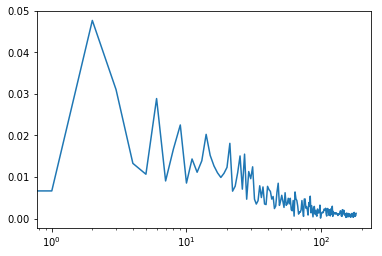

In [15]:
plt.semilogx(TFs)

## Run the above cells

In [6]:
#%%time
from itertools import product


datadir1 = '/g/data/v45/pm2987/Spunup_atpa/'
datadir2 = '/g/data/v45/pm2987/Spunup_atast/'
datadir3 = '/g/data/v45/pm2987/Spunup_ocsst/'
save_datapath = '/g/data/v45/pm2987/Transfer_maps/at/Tvar/'
name = 'atm_Tvar_1yrmaps_16Jan2020'

file_start = 5
file_end = 6
start_yr = 34

xi = range((97+tile_size+1)//(tile_size)) 
yi = range((385+tile_size+1)//(tile_size))

tile_indexes = list(product(*[yi, xi]))
print(tile_indexes)

var_name = 'Tdel2T'

# All files
ncfiles1 = sorted(glob(os.path.join(datadir1, 'output*/atpa.nc'))) # for all ocpo files
ncfiles2 = sorted(glob(os.path.join(datadir2, 'output*/atast.nc'))) # for all ocsst files
ncfiles3 = sorted(glob(os.path.join(datadir3, 'output*/ocsst.nc'))) # for Tma on ocean grid files

for i in np.arange(0,1):
    
    Ta2_sum = 0
    ToTa_sum = 0
    vert_adv_sum = 0
    Tum_sum = 0
    Tvm_sum = 0
    Fme_sum = 0
    Fs_sum = 0
    slh_sum = 0
    Tdel2T_sum = 0
    Tdel4T_sum = 0
    Tana_sum = 0
    Tn1_sum = 0
    TFs_sum = 0
    
    print('i = ',i)
    # Select desired files
    ncfiles1_loop = ncfiles1[file_start:file_end] #ncfiles1[(i*50):(i*50+100)] # 0 starts with year 233
    print(ncfiles1_loop[0],ncfiles1_loop[-1])
    
    chunks1 = {'xp': tile_size, 'yp': tile_size,'time':365, 'z':1, 'zi':1}
    datasets1 = [xr.open_dataset(fn,chunks=chunks1) for fn in ncfiles1_loop]
    dsx1 = xr.concat(datasets1, dim='time', coords='all')
    
    # Load ocsst
    ncfiles2_loop = ncfiles2[file_start:file_end] #ncfiles2[(i*50):(i*50+100)] # this errors if only loading one file (eg [0:1])
    print(ncfiles2_loop[0],ncfiles2_loop[-1])
    
    chunks2 = {'xt': tile_size, 'yt': tile_size,'time':365}
    datasets2 = [xr.open_dataset(fn,chunks=chunks2) for fn in ncfiles2_loop]
    dsx2 = xr.concat(datasets2, dim='time', coords='all')
    
    # Load atast
    ncfiles3_loop = ncfiles3[file_start:file_end] #ncfiles2[(i*50):(i*50+100)] # this errors if only loading one file (eg [0:1])
    print(ncfiles3_loop[0],ncfiles3_loop[-1])
    
    chunks3 = {'xt': tile_size, 'yt': tile_size,'time':365}
    datasets3 = [xr.open_dataset(fn,chunks=chunks3) for fn in ncfiles3_loop]
    dsx3 = xr.concat(datasets3, dim='time', coords='all')
    
    for tile_index in tile_indexes[:]:
        #if var_name == 'To2':
        #    Tmap = calc_To2(dsx2, tile_index)
        #    print(var_name)
        #if var_name == 'slh':
        #    Tmap = calc_slh(dsx2,dsx4,tile_index)
        #    
        #    print(var_name)
        #if var_name = 'ToTa':
        #    Tmap = calc_ToTa(dsx2,dsx4, tile_index, 2)
        #    
        #    print(var_name)
        #if i == 3:
        #    Tmap = calc_Fme(dsx2, tile_index, 0)
        #    var_name = 'Fme'
        #    print(var_name)
        #if i == 4:
        #    Tmap = calc_vert_adv(dsx2, tile_index, 1)
        #    var_name = 'vert_adv'
        #    print(var_name)
        #if var_name == 'H_adv':
        #    Tmap = calc_H_adv(dsx1,dsx2, tile_index)
        #    print(var_name)
        if var_name == 'Tdel2T':
            Tmap = calc_Tdel4T(dsx2, tile_index)
            print(var_name)
        #if i == 7:
        #    Tmap = calc_Tdel4T(dsx2, tile_index)
        #    var_name = 'Tdel4T'
        #    print(var_name)
        
        if tile_index[0] == 0:
            print('first if statement ',tile_index)
            Tmap_temp = np.copy(Tmap)
            print(Tmap_temp.shape)
        else:
            print('first else statement ',tile_index)
            Tmap_temp = np.concatenate((Tmap_temp,Tmap),axis=1)
            print(Tmap_temp.shape)
        
        Tmap_tot = np.copy(Tmap_temp)
            
        
                
    #for mapi in np.arange(1):
    #    print(mapi)
    #    Tgrp = Dataset(save_datapath+var_name+'_'+name+'_map'+str(mapi+1)+'_'+str(i+start_yr)+'_'+str(i+1+start_yr)+'.nc', 'w', format='NETCDF4') #3_CLASSIC')
    #    Tgrp.createDimension('yp',Tmap_tot.shape[0])
    #    Tgrp.createDimension('xp',Tmap_tot.shape[1])
    #    Tgrp.createDimension('w',Tmap_tot.shape[2])
    #    T = Tgrp.createVariable(var_name,'f4',('yp','xp','w'))
    #    print('T.shape = ',T.shape)
    #    print('Tmap_tot.shape = ',Tmap_tot.shape)
    #    T[:,:,:] = Tmap_tot[:,:,:] #(mapi*200):((mapi+1)*200)]
    #    Tgrp.close()
        
    #mapi = 18
    #Tgrp = Dataset(save_datapath+var_name+'_map'+str(mapi+1)+'_'+yrs+'.nc', 'w', format='NETCDF4') #_CLASSIC')
    #Tgrp.createDimension('yp',Tmap_tot.shape[0])
    #Tgrp.createDimension('xp',Tmap_tot.shape[1])
    #Tgrp.createDimension('w',51)
    #T = Tgrp.createVariable(var_name,'f4',('yp','xp','w'))
    #T[:,:,:] = Tmap_tot[:,:,mapi*200:] 
    #Tgrp.close()
    

[(0, 0), (1, 0), (2, 0), (3, 0)]
i =  0
/g/data/v45/pm2987/Spunup_atpa/output039/atpa.nc /g/data/v45/pm2987/Spunup_atpa/output039/atpa.nc
/g/data/v45/pm2987/Spunup_atast/output039/atast.nc /g/data/v45/pm2987/Spunup_atast/output039/atast.nc
/g/data/v45/pm2987/Spunup_ocsst/output039/ocsst.nc /g/data/v45/pm2987/Spunup_ocsst/output039/ocsst.nc


NameError: name 'calc_Tdel4T' is not defined

# OVER OCEAN 

## All terms of the form:

$$
{}^a \widehat{T}^* {}^o \widehat{T}
$$


In [6]:
def calc_ToTa(dsx1, dsx2, tile_index):
    # Select variables
    To = dsx2.sst
    Ta = dsx1.ast
    hm = dsx1.hmixa
    print('Ta shape = ',Ta.shape)
    print('To shape = ',To.shape)
    
    # Work with DaskArrays
    ix, iy = tile_index
    print('ix and iy = ',ix,iy)
    
    Ta = Ta.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(ix*tile_size, (ix+1)*tile_size))
    hm = hm.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(ix*tile_size, (ix+1)*tile_size))
    
    print('Ta.shape = ',Ta.shape)
    
    # Select the points only over the ocean
    # For To: first 38*16 points are in first chunk (38 atm points * 16 atm points per oc point)
    if ix == 1:
        print('ix==1')
        Ta = Ta.isel(yt=slice(18,-18),xt=slice(62,None))
        To = To.isel(xt=slice(None, 38*16))
        hm = hm.isel(yt=slice(18,-18),xt=slice(62,None))
        print('Ta.shape = ',Ta.shape)
        print('To.shape = ',To.shape)
    
    elif ix == 2:
        Ta = Ta.isel(yt=slice(18,-18),xt=slice(None,22))
        To = To.isel(xt=slice(38*16,None))
        hm = hm.isel(yt=slice(18,-18),xt=slice(None,22))
        print('Ta.shape = ',Ta.shape)
        print('To.shape = ',To.shape)
    
    xt = Ta.xt.values
    yt = Ta.yt.values
    time = Ta.time.values
    
    To = To.data
    Ta = Ta.data
    
    ny, nx, nt = Ta.shape

    # Average To onto atm grid and divide by hm
    if ix == 1:
        print('ix==1')
        To = np.reshape(To,(int(960/16),16,int((38*16)/16),16,nt))
        print(To.shape)
        To = (1/(16*16))*np.sum(To,axis=(1,3))
        To = To/hm
        print(To.shape)
    elif ix == 2:
        To = np.reshape(To,(int(960/16),16,int((960 - (38*16))/16),16,nt))
        To = (1/(16*16))*np.sum(To,axis=(1,3))
        To = To/hm
        print(To.shape)
    
    # Take fft (after detrend and window)
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Resize for faster FFT
    To = To.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    Ta = Ta.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})

    # Execute fft function above
    Tohat = To.map_blocks(fft_block)
    Tahat = Ta.map_blocks(fft_block)
    
    # Resize back to original tile size (100)
    Tohat = Tohat.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    Tahat = Tahat.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    
    print('Tohat and Tahat shapes = ',Tohat.shape,Tahat.shape)
    
    # Multiply by constants
    ToTa = (Tahat.conj()*Tohat).real

    # Sum over x- and y-axes
    ToTa = da.sum(ToTa, axis=(0,1))
    
    ToTa = ToTa.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    ToTa = xr.DataArray(ToTa,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xt': xt.mean(),
                              'yt': yt.mean()})
    
    return ToTa

In [9]:
ToTa_tile = calc_ToTa(dsx2,dsx3,(1,0))

Ta shape =  (96, 384, 365)
To shape =  (960, 960, 365)
ix and iy =  1 0
Ta.shape =  (96, 100, 365)
ix==1
Ta.shape =  (60, 38, 365)
To.shape =  (960, 608, 365)
ix==1
(60, 16, 38, 16, 365)
(60, 38, 365)
Tohat and Tahat shapes =  (60, 38, 365) (60, 38, 365)


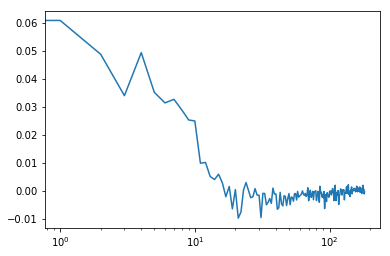

In [10]:
plt.semilogx(ToTa_tile)

## All terms of the form:

$$
{}^a \widehat{T}^* {}^a \widehat{T}
$$


In [18]:
def calc_Ta2o(dsx1, tile_index):
    # Select variables
    T = dsx1.ast
    hm = dsx1.hmixa
    
    # Work with DaskArrays
    ix, iy = tile_index
    T = T.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(ix*tile_size, (ix+1)*tile_size))
    hm = hm.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(ix*tile_size, (ix+1)*tile_size))
    
    print('T shape after isel = ',T.shape)
    
    # Select the points only over the ocean
    if ix == 1:
        print('ix==1')
        T = T.isel(yt=slice(18,-18),xt=slice(62,None))
        hm = hm.isel(yt=slice(18,-18),xt=slice(62,None))
        print('T.shape = ',T.shape)
  
    elif ix == 2:
        T = T.isel(yt=slice(18,-18),xt=slice(None,22))
        hm = hm.isel(yt=slice(18,-18),xt=slice(None,22))
        print('T.shape = ',T.shape)
    
    xt = T.xt.values
    yt = T.yt.values
    time = T.time.values
    
    T = T.data
    
    ny, nx, nt = T.shape

    # Divide by hm and save as new variable Thm
    Thm = T/hm
 
    # Take fft (after detrend and window)
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Resize for faster FFT
    T = T.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    Thm = Thm.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})

    # Execute fft function above
    That = T.map_blocks(fft_block)
    Thmhat = Thm.map_blocks(fft_block)
    
    # Resize back to original tile size (100)
    That = That.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    Thmhat = Thmhat.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    
    # Multiply by constants
    Ta2 = (That.conj()*Thmhat).real

    # Sum over x- and y-axes
    Ta2 = da.sum(Ta2, axis=(0,1))
    
    Ta2 = Ta2.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    Ta2 = xr.DataArray(Ta2,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xt': xt.mean(),
                              'yt': yt.mean()})
    
    return Ta2

In [19]:
Ta2o_tile = calc_Ta2o(dsx2,(1,0))

T shape after isel =  (96, 100, 365)
ix==1
T.shape =  (60, 38, 365)
Original shape =  (60, 38, 365)


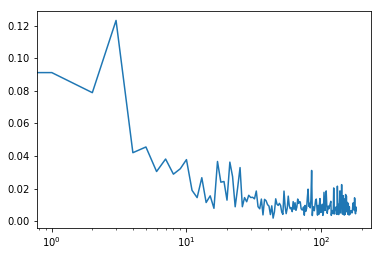

In [20]:
plt.semilogx(Ta2o_tile)

# Calculate sensible and latent heat 

$$
\widehat{T^a}^* \widehat{(T^o - T^a)}
$$

In [21]:
def calc_slh(dsx1, dsx2, tile_index):
    # Select variables
    To = dsx2.sst
    Ta = dsx1.ast
    hm = dsx1.hmixa
    print('Ta shape = ',Ta.shape)
    print('To shape = ',To.shape)
    
    # Work with DaskArrays
    ix, iy = tile_index
    print('ix and iy = ',ix,iy)
    
    Ta = Ta.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(ix*tile_size, (ix+1)*tile_size))
    hm = hm.isel(yt=slice(iy*tile_size, (iy+1)*tile_size),
                 xt=slice(ix*tile_size, (ix+1)*tile_size))
    
    print('Ta.shape = ',Ta.shape)
    
    # Select the points only over the ocean
    # For To: first 38*16 points are in first chunk (38 atm points * 16 atm points per oc point)
    if ix == 1:
        print('ix==1')
        Ta = Ta.isel(yt=slice(18,-18),xt=slice(62,None))
        hm = hm.isel(yt=slice(18,-18),xt=slice(62,None))
        To = To.isel(xt=slice(None, 38*16))
        print('Ta.shape = ',Ta.shape)
        print('To.shape = ',To.shape)
  
    elif ix == 2:
        Ta = Ta.isel(yt=slice(18,-18),xt=slice(None,22))
        hm = hm.isel(yt=slice(18,-18),xt=slice(None,22))
        To = To.isel(xt=slice(38*16,None))
        print('Ta.shape = ',Ta.shape)
        print('To.shape = ',To.shape)
    
    xt = Ta.xt.values
    yt = Ta.yt.values
    time = Ta.time.values
    
    To = To.data
    Ta = Ta.data

    ny, nx, nt = Ta.shape

    # Average To onto atm grid
    if ix == 1:
        print('ix==1')
        To = np.reshape(To,(int(960/16),16,int(608/16),16,nt))
        print(To.shape)
        To = (1/(16*16))*np.sum(To,axis=(1,3))
        print(To.shape)
    elif ix == 2:
        To = np.reshape(To,(int(960/16),16,int((960 - 608)/16),16,nt))
        To = (1/(16*16))*np.sum(To,axis=(1,3))
        print(To.shape)
    
    # Divide by hm
    To_minus_Ta = (To - Ta)/hm
    print('To_minus_Ta.shape = ',To_minus_Ta.shape)
    
    # Take fft (after detrend and window)
    def fft_block(var): # var is numpy array
        var = detrend_func(var,'time')
        var = window_func(var,'time')
        varhat = (1.0/var.shape[2])*np.fft.rfft(var, axis=2)
        return varhat
    
    # Resize for faster FFT
    To_minus_Ta = To_minus_Ta.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})
    Ta = Ta.rechunk(chunks={0: tile_size/10, 1: tile_size/10, 2: nt})

    # Execute fft function above
    To_minus_Ta_hat = To_minus_Ta.map_blocks(fft_block)
    Tahat = Ta.map_blocks(fft_block)
    
    # Resize back to original tile size (100)
    To_minus_Ta_hat = To_minus_Ta_hat.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    Tahat = Tahat.rechunk(chunks={0: tile_size, 
                                  1: tile_size, 
                                  2: 365})
    
    print('Tohat and Tahat shapes = ',To_minus_Ta_hat.shape,Tahat.shape)
    
    # Multiply by constants
    slh = (Tahat.conj()*To_minus_Ta_hat).real

    # Sum over x- and y-axes
    slh = da.sum(slh, axis=(0,1))
    
    slh = slh.compute()
    
    # wrap as DataArray
    n = len(time)
    d = time[1] - time[0]
    freq = np.fft.rfftfreq(n, d)
    
    slh = xr.DataArray(slh,
                      dims=['freq'], 
                      coords={'freq': freq,
                              'xt': xt.mean(),
                              'yt': yt.mean()})
    
    return slh

In [22]:
slh_tile = calc_slh(dsx2,dsx3,(1,0))

Ta shape =  (96, 384, 365)
To shape =  (960, 960, 365)
ix and iy =  1 0
Ta.shape =  (96, 100, 365)
ix==1
Ta.shape =  (60, 38, 365)
To.shape =  (960, 608, 365)
ix==1
(60, 16, 38, 16, 365)
(60, 38, 365)
To_minus_Ta.shape =  (60, 38, 365)
Tohat and Tahat shapes =  (60, 38, 365) (60, 38, 365)


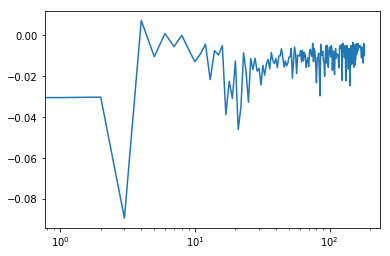

In [23]:
plt.semilogx(slh_tile)

## Run the above over-ocean cells

In [8]:
%%time
from itertools import product

datadir1 = '/g/data/v45/pm2987/Spunup_atpa/'
datadir2 = '/g/data/v45/pm2987/Spunup_atast/'
datadir3 = '/g/data/v45/pm2987/Spunup_ocsst/'
save_datapath = '/g/data/v45/pm2987/SpecTransfers_Tvar/'
name = 'atm_Tvar_16Jan2020'

file_start = 0
file_end = 1
start_yr = 34

xi = range((97+tile_size+1)//(tile_size)) 
#yi = range((385+tile_size+1)//(tile_size))
yi = range(1,3)

tile_indexes = list(product(*[yi, xi]))
print(tile_indexes)

# All files
ncfiles1 = sorted(glob(os.path.join(datadir1, 'output*/atpa.nc'))) # for all ocpo files
ncfiles2 = sorted(glob(os.path.join(datadir2, 'output*/atast.nc'))) # for all ocsst files
ncfiles3 = sorted(glob(os.path.join(datadir3, 'output*/ocsst.nc'))) # for Tma on ocean grid files

for i in np.arange(0,1):
    
    Ta2_sum = 0
    ToTa_sum = 0
    vert_adv_sum = 0
    Tum_sum = 0
    Tvm_sum = 0
    Fme_sum = 0
    Fs_sum = 0
    slh_sum = 0
    Tdel2T_sum = 0
    Tdel4T_sum = 0
    Tana_sum = 0
    Tn1_sum = 0
    
    print('i = ',i)
    # Select desired files
    ncfiles1_loop = ncfiles1[file_start:file_end] #ncfiles1[(i*50):(i*50+100)] # 0 starts with year 233
    print(ncfiles1_loop[0],ncfiles1_loop[-1])
    
    chunks1 = {'xp': tile_size, 'yp': tile_size,'time':365, 'z':1, 'zi':1}
    datasets1 = [xr.open_dataset(fn,chunks=chunks1) for fn in ncfiles1_loop]
    dsx1 = xr.concat(datasets1, dim='time', coords='all')
    
    # Load ocsst
    ncfiles2_loop = ncfiles2[file_start:file_end] #ncfiles2[(i*50):(i*50+100)] # this errors if only loading one file (eg [0:1])
    print(ncfiles2_loop[0],ncfiles2_loop[-1])
    
    chunks2 = {'xt': tile_size, 'yt': tile_size,'time':365}
    datasets2 = [xr.open_dataset(fn,chunks=chunks2) for fn in ncfiles2_loop]
    dsx2 = xr.concat(datasets2, dim='time', coords='all')
    
    # Load atast
    ncfiles3_loop = ncfiles3[file_start:file_end] #ncfiles2[(i*50):(i*50+100)] # this errors if only loading one file (eg [0:1])
    print(ncfiles3_loop[0],ncfiles3_loop[-1])
    
    chunks3 = {'xt': tile_size, 'yt': tile_size,'time':365}
    datasets3 = [xr.open_dataset(fn,chunks=chunks3) for fn in ncfiles3_loop]
    dsx3 = xr.concat(datasets3, dim='time', coords='all')
    
    for tile_index in tile_indexes[:]:
        print('calculating Ta2o...',tile_index)
        
        Ta2 = calc_Ta2o(dsx2,tile_index)
        Ta2_sum += Ta2
    #
    #np.save(save_datapath+'Ta2o_'+name+'_'+str(i+start_yr)+'_'+str(i+start_yr),To2_sum) # 1yr test

      
    #for tile_index in tile_indexes[:]:
    #    print('calculating ToTa...',tile_index)
    #    
    #    ToTa = calc_ToTa(dsx2,dsx3,tile_index)
    #    ToTa_sum += ToTa
    #    
    #np.save(save_datapath+'ToTa_'+name+'_'+str(i+start_yr)+'_'+str(i+1+start_yr),ToTa_sum)
    
    #for tile_index in tile_indexes[:]:
    #    print('calculating slh...',tile_index)
    #    
    #    slh = calc_slh(dsx2,dsx3,tile_index)
    #    slh_sum += slh
    #    
    #np.save(save_datapath+'slh_'+name+'_'+str(i+start_yr)+'_'+str(i+1+start_yr),slh_sum)
       


[(1, 0), (2, 0)]
i =  0
/g/data/v45/pm2987/Spunup_atpa/output034/atpa.nc /g/data/v45/pm2987/Spunup_atpa/output034/atpa.nc
/g/data/v45/pm2987/Spunup_atast/output034/atast.nc /g/data/v45/pm2987/Spunup_atast/output034/atast.nc
/g/data/v45/pm2987/Spunup_ocsst/output034/ocsst.nc /g/data/v45/pm2987/Spunup_ocsst/output034/ocsst.nc
calculating Ta2o... (1, 0)


NameError: name 'calc_Ta2o' is not defined